In [8]:
import os
import shap
import random
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, cohen_kappa_score
from keras.models import Model
from keras import optimizers, applications
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.layers import Dense, Dropout, GlobalAveragePooling2D, Input
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import layers, models, optimizers, regularizers

%matplotlib inline
sns.set(style="whitegrid")
warnings.filterwarnings("ignore")

# Load the data

In [9]:
train = pd.read_csv('/kaggle/input/aptos2019-blindness-detection/train.csv')
test = pd.read_csv('/kaggle/input/aptos2019-blindness-detection/test.csv')
print('Number of train samples: ', train.shape[0])
print('Number of test samples: ', test.shape[0])

# Preprocecss data
train["id_code"] = train["id_code"].apply(lambda x: x + ".png")
test["id_code"] = test["id_code"].apply(lambda x: x + ".png")
train['diagnosis'] = train['diagnosis'].astype('str')
display(train.head())

Number of train samples:  3662
Number of test samples:  1928


,id_code,diagnosis
0,000c1434d8d7.png,2
1,001639a390f0.png,4
2,0024cdab0c1e.png,1
3,002c21358ce6.png,0
4,005b95c28852.png,0


# Model Parameters

In [10]:
# Model parameters
BATCH_SIZE = 8
EPOCHS = 40
WARMUP_EPOCHS = 2
LEARNING_RATE = 1e-4
WARMUP_LEARNING_RATE = 1e-3
HEIGHT = 400
WIDTH = 400
CANAL = 3
N_CLASSES = train['diagnosis'].nunique()
ES_PATIENCE = 5
RLROP_PATIENCE = 3
DECAY_DROP = 0.5

In [11]:
import cv2
import numpy as np

def crop_image_from_gray(img, tol=7):
    """
    Applies masks to the original image and
    returns the cropped image with appropriate channels.
    
    :param img: A NumPy Array that will be cropped (grayscale or RGB)
    :param tol: The tolerance used for masking
    
    :return: A NumPy array containing the cropped image
    """
    # If the image is grayscale (2D array)
    if img.ndim == 2:
        mask = img > tol
        return img[np.ix_(mask.any(1), mask.any(0))]
    
    # If the image has 3 channels (RGB)
    elif img.ndim == 3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img > tol
        
        check_shape = img[:, :, 0][np.ix_(mask.any(1), mask.any(0))].shape[0]
        if check_shape == 0:  # If the image is too dark and crops everything
            return img  # Return the original image
        else:
            img1 = img[:, :, 0][np.ix_(mask.any(1), mask.any(0))]
            img2 = img[:, :, 1][np.ix_(mask.any(1), mask.any(0))]
            img3 = img[:, :, 2][np.ix_(mask.any(1), mask.any(0))]
            img = np.stack([img1, img2, img3], axis=-1)
        return img

def preprocess_image(image, sigmaX=10):
    """
    Preprocessing pipeline:
    1. Convert BGR to RGB (if applicable)
    2. Crop the image from gray regions
    3. Resize the image to 400x400
    4. Apply Gaussian blur to enhance robustness
    5. Normalize the image
    
    :param image: A NumPy Array of the image (grayscale or color)
    :param sigmaX: Value used to apply GaussianBlur
    
    :return: A NumPy array containing the preprocessed image
    """
    # Check if the image is grayscale (2D array)
    if image.ndim == 2:
        is_gray = True
    else:
        is_gray = False
        # Convert BGR to RGB (since OpenCV loads color images as BGR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Crop the image from gray regions
    cropped_image = crop_image_from_gray(image)
    
    # Ensure the cropped image is 800x800 (if larger, center crop)
    height, width = cropped_image.shape[:2]
    if height > 800 and width > 800:
        startx = width // 2 - (800 // 2)
        starty = height // 2 - (800 // 2)
        cropped_image = cropped_image[starty:starty+800, startx:startx+800]
    
    # Resize the image to 400x400
    resized_image = cv2.resize(cropped_image, (400, 400))
    
    # Apply Gaussian blur for robustness
    if is_gray:
        preprocessed_image = cv2.addWeighted(resized_image, 4, 
                                             cv2.GaussianBlur(resized_image, (0, 0), sigmaX), -4, 128)
    else:
        preprocessed_image = cv2.addWeighted(resized_image, 4, 
                                             cv2.GaussianBlur(resized_image, (0, 0), sigmaX), -4, 128)
    
    # Normalize the image (convert to float32 and scale by 1/255)
    preprocessed_image = preprocessed_image.astype(np.float32) / 255.0
    
    return preprocessed_image


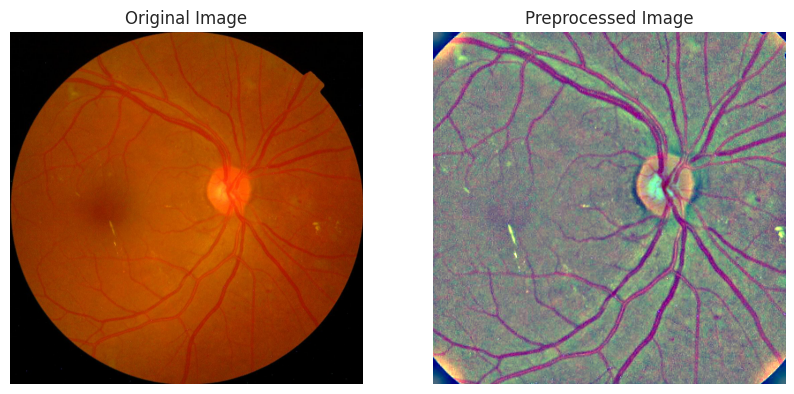

In [12]:
# Load an example image (you can replace 'your_image.jpg' with any image path)
image_path = '/kaggle/input/aptos2019-blindness-detection/test_images/096d6bb6546b.png'
image = cv2.imread(image_path)

# Preprocess the image
preprocessed_image = preprocess_image(image)

# Display the original and preprocessed images using matplotlib
plt.figure(figsize=(10, 5))

# Show original image
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.axis('off')

# Show preprocessed image
plt.subplot(1, 2, 2)
plt.imshow(preprocessed_image)
plt.title('Preprocessed Image')
plt.axis('off')

plt.show()

# Train test split

In [13]:
#X_train, X_val = train_test_split(train, test_size=0.2, random_state=123)
X_train, X_test = train_test_split(train, test_size=0.2, random_state=123)

# Data Generator

In [14]:
train_datagen=ImageDataGenerator( 
                                 rotation_range=360,
                                 horizontal_flip=True,
                                 vertical_flip=True,
                                 validation_split=0.1,
                                 preprocessing_function=preprocess_image)

train_generator=train_datagen.flow_from_dataframe(
    dataframe=X_train,
    directory="/kaggle/input/aptos2019-blindness-detection/train_images",
    x_col="id_code",
    y_col="diagnosis",
    class_mode="categorical",
    batch_size=BATCH_SIZE,
    target_size=(HEIGHT, WIDTH),
    seed=0,
    subset='training')

validation_datagen = ImageDataGenerator(preprocessing_function=preprocess_image)

valid_generator=train_datagen.flow_from_dataframe(
    dataframe=X_train,
    directory="/kaggle/input/aptos2019-blindness-detection/train_images",
    x_col="id_code",
    y_col="diagnosis",
    class_mode="categorical", 
    batch_size=BATCH_SIZE,   
    target_size=(HEIGHT,WIDTH),
    seed=0,
    subset= 'validation')

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_image)

test_generator = test_datagen.flow_from_dataframe(  
        dataframe=X_test,
        directory = "/kaggle/input/aptos2019-blindness-detection/train_images",
        x_col="id_code",
        y_col="diagnosis",
        batch_size=1,
        class_mode="categorical",
        shuffle=False,
        target_size=(HEIGHT, WIDTH),
        seed=0)

Found 2637 validated image filenames belonging to 5 classes.
Found 292 validated image filenames belonging to 5 classes.
Found 733 validated image filenames belonging to 5 classes.


# Model

In [39]:
def create_model(input_shape, n_out):
    input_tensor = Input(shape=input_shape)
    
    # Use EfficientNetB0 as the base model instead of ResNet50
    base_model = EfficientNetB0(weights='imagenet', 
                                include_top=False,
                                input_tensor=input_tensor)
    
    # Add global average pooling and dense layers
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dropout(0.7)(x)
    x = Dense(2048, activation='relu',kernel_regularizer=regularizers.l2(0.01))(x)  # Fully connected layer
    x = Dropout(0.5)(x)
    final_output = Dense(n_out, activation='softmax', name='final_output')(x)  # Output layer for classification
    
    # Create the model
    model = Model(inputs=input_tensor, outputs=final_output)
    
    return model

In [40]:
# Define the model
model = create_model(input_shape=(HEIGHT, WIDTH, CANAL), n_out=N_CLASSES)

# Freeze all layers initially
for layer in model.layers:
    layer.trainable = False

# Unfreeze the last 5 layers for fine-tuning
for i in range(-5, 0):
    model.layers[i].trainable = True

# Compute class weights to handle imbalanced data
class_weights = class_weight.compute_class_weight(
    class_weight='balanced', 
    classes=np.unique(train['diagnosis'].astype('int').values), 
    y=train['diagnosis'].astype('int').values
)

# Compile the model with Adam optimizer and categorical cross-entropy loss
metric_list = ["accuracy"]
optimizer = optimizers.Adam(learning_rate=WARMUP_LEARNING_RATE)  # Ensure the correct learning rate is used
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=metric_list)

# Print the model summary
model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 400, 400,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_6         │ (None, 400, 400,  │          0 │ input_layer_3[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization_3     │ (None, 400, 400,  │          7 │ rescaling_6[0][0] │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_7         │ (None, 400, 400,  │          0 │ normalization_3[… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 401, 401,  │          0 │ rescaling_7[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 200, 200,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 200, 200,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 200, 200,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 200, 200,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 200, 200,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 200, 200,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 200, 200,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 200, 200,  │        512 │ block1a_se_excit

 Total params: 6,683,304 (25.49 MB)

 Trainable params: 2,633,733 (10.05 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [41]:
from sklearn.utils import class_weight
import numpy as np

# Compute class weights
class_weights_array = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train['diagnosis'].astype('int').values),
    y=train['diagnosis'].astype('int').values
)

# Create a class weights dictionary
class_weights_dict = {i: class_weights_array[i] for i in range(len(class_weights_array))}

# Define steps per epoch
STEP_SIZE_TRAIN = train_generator.n // train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n // valid_generator.batch_size

# Fit the model
history_warmup = model.fit(
    train_generator,
    steps_per_epoch=STEP_SIZE_TRAIN,
    validation_data=valid_generator,
    validation_steps=STEP_SIZE_VALID,
    epochs=WARMUP_EPOCHS,
    class_weight=class_weights_dict,  # Use the dictionary here
    verbose=1
).history


Epoch 1/2
329/329 ━━━━━━━━━━━━━━━━━━━━ 483s 1s/step - accuracy: 0.1959 - loss: 6.3081 - val_accuracy: 0.5243 - val_loss: 1.6783
Epoch 2/2
329/329 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.1250 - loss: 2.6648 - val_accuracy: 1.0000 - val_loss: 1.5363


# Fine tune the complete model


In [42]:
for layer in model.layers:
    layer.trainable = True

es = EarlyStopping(monitor='val_loss', mode='min', patience=ES_PATIENCE, restore_best_weights=True, verbose=1)
rlrop = ReduceLROnPlateau(monitor='val_loss', mode='min', patience=RLROP_PATIENCE, factor=DECAY_DROP, min_lr=1e-6, verbose=1)

callback_list = [es, rlrop]
optimizer = optimizers.Adam(learning_rate=LEARNING_RATE)
model.compile(optimizer=optimizer, loss='categorical_crossentropy',  metrics=metric_list)
model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 400, 400,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_6         │ (None, 400, 400,  │          0 │ input_layer_3[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization_3     │ (None, 400, 400,  │          7 │ rescaling_6[0][0] │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_7         │ (None, 400, 400,  │          0 │ normalization_3[… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 401, 401,  │          0 │ rescaling_7[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 200, 200,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 200, 200,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 200, 200,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 200, 200,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 200, 200,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 200, 200,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 200, 200,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 200, 200,  │        512 │ block1a_se_excit

 Total params: 6,683,304 (25.49 MB)

 Trainable params: 6,641,281 (25.33 MB)

 Non-trainable params: 42,023 (164.16 KB)

In [43]:
history_finetunning = model.fit(train_generator,
                                          steps_per_epoch=STEP_SIZE_TRAIN,
                                          validation_data=valid_generator,
                                          validation_steps=STEP_SIZE_VALID,
                                          epochs=EPOCHS,
                                          callbacks=callback_list,
                                          class_weight=class_weights_dict,
                                          verbose=1).history

Epoch 1/40
329/329 ━━━━━━━━━━━━━━━━━━━━ 562s 1s/step - accuracy: 0.5544 - loss: 1.5515 - val_accuracy: 0.3333 - val_loss: 1.6907 - learning_rate: 1.0000e-04
Epoch 2/40
329/329 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.8750 - loss: 0.7875 - val_accuracy: 0.2500 - val_loss: 1.6999 - learning_rate: 1.0000e-04
Epoch 3/40
329/329 ━━━━━━━━━━━━━━━━━━━━ 432s 1s/step - accuracy: 0.6855 - loss: 1.1710 - val_accuracy: 0.5903 - val_loss: 1.0830 - learning_rate: 1.0000e-04
Epoch 4/40
329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8750 - loss: 0.7921 - val_accuracy: 0.7500 - val_loss: 0.6212 - learning_rate: 1.0000e-04
Epoch 5/40
329/329 ━━━━━━━━━━━━━━━━━━━━ 433s 1s/step - accuracy: 0.6877 - loss: 1.0705 - val_accuracy: 0.7500 - val_loss: 0.7130 - learning_rate: 1.0000e-04
Epoch 6/40
329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6250 - loss: 0.9721 - val_accuracy: 0.2500 - val_loss: 1.2646 - learning_rate: 1.0000e-04
Epoch 7/40
329/329 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy

# Model loss Graph

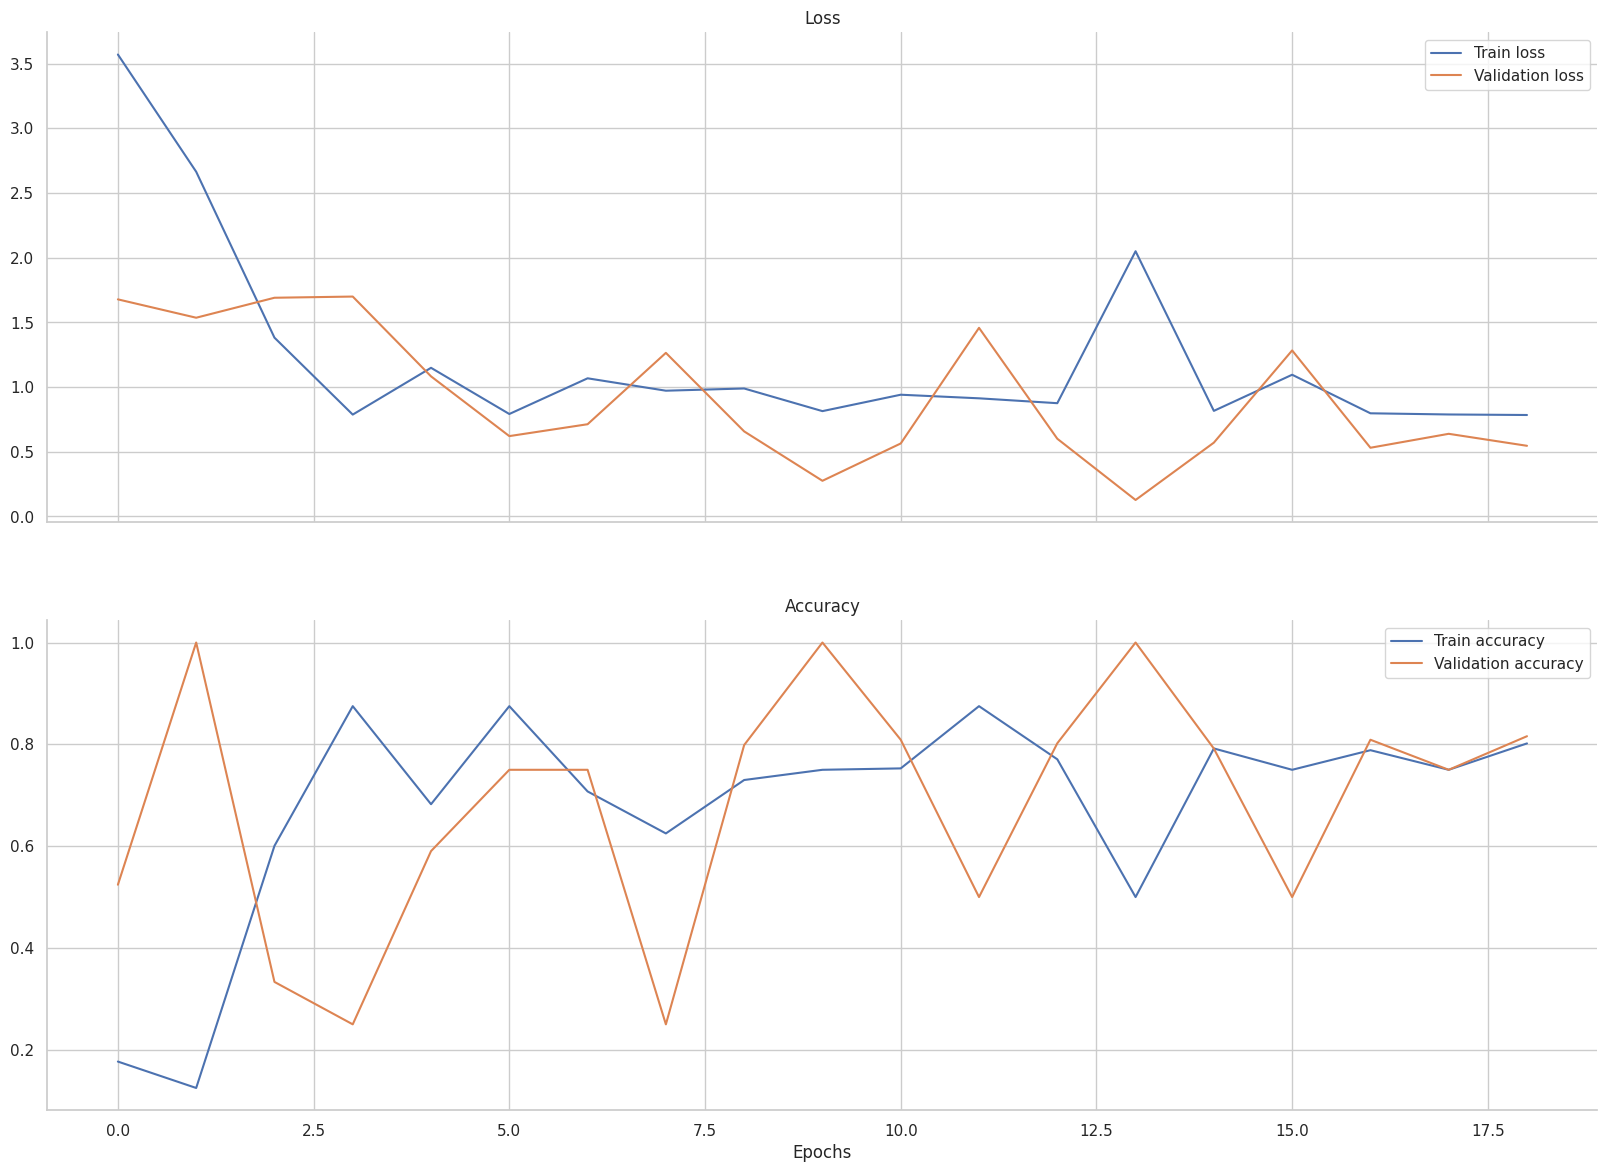

In [44]:
history = {'loss': history_warmup['loss'] + history_finetunning['loss'], 
           'val_loss': history_warmup['val_loss'] + history_finetunning['val_loss'], 
           'accuracy': history_warmup['accuracy'] + history_finetunning['accuracy'], 
           'val_accuracy': history_warmup['val_accuracy'] + history_finetunning['val_accuracy']}

sns.set_style("whitegrid")
fig, (ax1, ax2) = plt.subplots(2, 1, sharex='col', figsize=(20, 14))

ax1.plot(history['loss'], label='Train loss')
ax1.plot(history['val_loss'], label='Validation loss')
ax1.legend(loc='best')
ax1.set_title('Loss')

ax2.plot(history['accuracy'], label='Train accuracy')
ax2.plot(history['val_accuracy'], label='Validation accuracy')
ax2.legend(loc='best')
ax2.set_title('Accuracy')

plt.xlabel('Epochs')
sns.despine()
plt.show()

# Model Evaluation 

In [45]:
# Create empty arays to keep the predictions and labels
lastFullTrainPred = np.empty((0, N_CLASSES))
lastFullTrainLabels = np.empty((0, N_CLASSES))
lastFullValPred = np.empty((0, N_CLASSES))
lastFullValLabels = np.empty((0, N_CLASSES))

# Add train predictions and labels
for i in range(STEP_SIZE_TRAIN+1):
    im, lbl = next(train_generator)
    scores = model.predict(im, batch_size=train_generator.batch_size)
    lastFullTrainPred = np.append(lastFullTrainPred, scores, axis=0)
    lastFullTrainLabels = np.append(lastFullTrainLabels, lbl, axis=0)

# Add validation predictions and labels
for i in range(STEP_SIZE_VALID+1):
    im, lbl = next(valid_generator)
    scores = model.predict(im, batch_size=valid_generator.batch_size)
    lastFullValPred = np.append(lastFullValPred, scores, axis=0)
    lastFullValLabels = np.append(lastFullValLabels, lbl, axis=0)
    
    
lastFullComPred = np.concatenate((lastFullTrainPred, lastFullValPred))
lastFullComLabels = np.concatenate((lastFullTrainLabels, lastFullValLabels))
complete_labels = [np.argmax(label) for label in lastFullComLabels]

train_preds = [np.argmax(pred) for pred in lastFullTrainPred]
train_labels = [np.argmax(label) for label in lastFullTrainLabels]
validation_preds = [np.argmax(pred) for pred in lastFullValPred]
validation_labels = [np.argmax(label) for label in lastFullValLabels]

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━

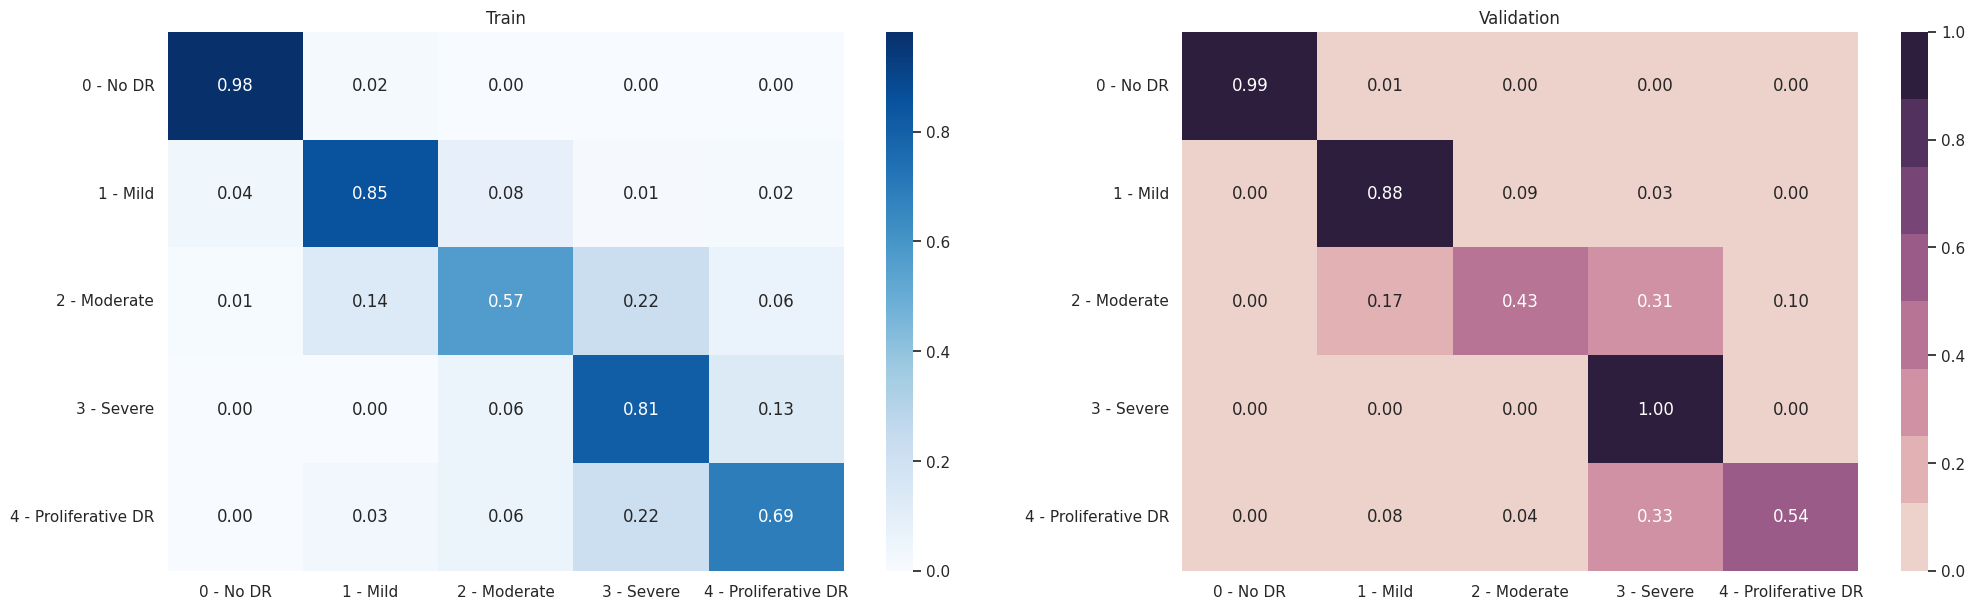

In [46]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharex='col', figsize=(24, 7))
labels = ['0 - No DR', '1 - Mild', '2 - Moderate', '3 - Severe', '4 - Proliferative DR']
train_cnf_matrix = confusion_matrix(train_labels, train_preds)
validation_cnf_matrix = confusion_matrix(validation_labels, validation_preds)

train_cnf_matrix_norm = train_cnf_matrix.astype('float') / train_cnf_matrix.sum(axis=1)[:, np.newaxis]
validation_cnf_matrix_norm = validation_cnf_matrix.astype('float') / validation_cnf_matrix.sum(axis=1)[:, np.newaxis]

train_df_cm = pd.DataFrame(train_cnf_matrix_norm, index=labels, columns=labels)
validation_df_cm = pd.DataFrame(validation_cnf_matrix_norm, index=labels, columns=labels)

sns.heatmap(train_df_cm, annot=True, fmt='.2f', cmap="Blues", ax=ax1).set_title('Train')
sns.heatmap(validation_df_cm, annot=True, fmt='.2f', cmap=sns.cubehelix_palette(8), ax=ax2).set_title('Validation')
plt.show()

# Quadratic Weighted Kappa

In [47]:
print("Train Cohen Kappa score: %.3f" % cohen_kappa_score(train_preds,train_labels, weights='quadratic'))
print("Validation Cohen Kappa score: %.3f" % cohen_kappa_score(validation_preds, validation_labels, weights='quadratic'))
print("Complete set Cohen Kappa score: %.3f" % cohen_kappa_score(train_preds+validation_preds, train_labels+validation_labels, weights='quadratic'))

Train Cohen Kappa score: 0.920
Validation Cohen Kappa score: 0.900
Complete set Cohen Kappa score: 0.918


In [4]:
from tensorflow.keras.models import load_model

# Load the model from the output directory
model_loaded = load_model('/kaggle/input/efficient-model-400x400-top-model/tensorflow2/default/1/top efficient B0 multi.h5')  # Adjust path if necessary

# Verify that the model is loaded
model_loaded.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 400, 400,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_6         │ (None, 400, 400,  │          0 │ input_layer_3[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization_3     │ (None, 400, 400,  │          7 │ rescaling_6[0][0] │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_7         │ (None, 400, 400,  │          0 │ normalization_3[… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 401, 401,  │          0 │ rescaling_7[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 200, 200,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 200, 200,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 200, 200,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 200, 200,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 200, 200,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 200, 200,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 200, 200,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 200, 200,  │        512 │ block1a_se_excit

 Total params: 6,683,306 (25.49 MB)

 Trainable params: 6,641,281 (25.33 MB)

 Non-trainable params: 42,023 (164.16 KB)

 Optimizer params: 2 (12.00 B)

# Evalution On Test Data

In [15]:
# Example: Use model to make predictions on test data
test_loss, test_acc = model.evaluate(test_generator)
print("Test accuracy:", test_acc)

# Make predictions
predictions = model_loaded.predict(test_generator)


733/733 ━━━━━━━━━━━━━━━━━━━━ 182s 242ms/step - accuracy: 0.7699 - loss: 0.6461
Test accuracy: 0.7557981014251709
733/733 ━━━━━━━━━━━━━━━━━━━━ 157s 212ms/step


In [38]:
STEP_SIZE_TEST = test_generator.n // test_generator.batch_size

In [39]:
import numpy as np

# Get the true labels and predicted probabilities from the test generator
test_labels = []
test_preds = []

# Loop through the test generator to get predictions and true labels
for i in range(STEP_SIZE_TEST):  # Adjust to match the number of test batches
    im, lbl = next(test_generator)  # Get a batch of images and labels
    scores = model_loaded.predict(im, batch_size=test_generator.batch_size)  # Predict probabilities
    test_preds.append(scores)  # Append predicted probabilities
    test_labels.append(lbl)  # Append true labels

# Convert lists to numpy arrays
test_preds = np.vstack(test_preds)  # Stack all predictions
test_labels = np.vstack(test_labels)  # Stack all true labels


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

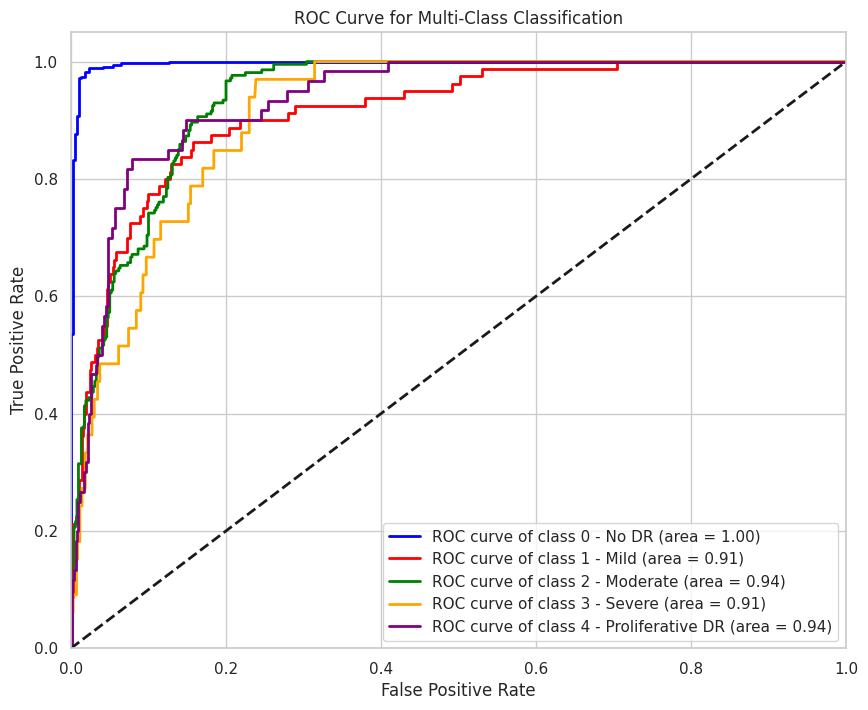

In [40]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from itertools import cycle
import numpy as np

# Assuming you have 5 classes
n_classes = 5
labels = ['0 - No DR', '1 - Mild', '2 - Moderate', '3 - Severe', '4 - Proliferative DR']

# Initialize dictionaries for False Positive Rate (fpr), True Positive Rate (tpr), and roc_auc
fpr = dict()
tpr = dict()
roc_auc = dict()

# Calculate ROC curve and AUC for each class
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(test_labels[:, i], test_preds[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure(figsize=(10, 8))
colors = cycle(['blue', 'red', 'green', 'orange', 'purple'])

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'.format(labels[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)  # Diagonal line for a random classifier
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Multi-Class Classification')
plt.legend(loc="lower right")
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

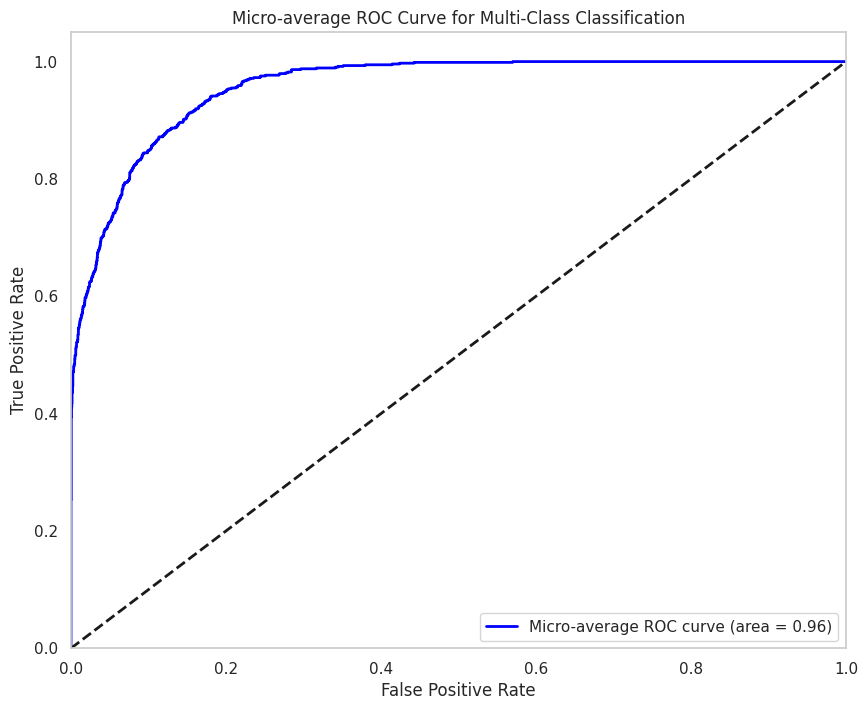

Micro-average AUC: 0.96


In [42]:
import numpy as np
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Get the true labels and predicted probabilities from the test generator
test_labels = []
test_preds = []

# Loop through the test generator to get predictions and true labels
for i in range(STEP_SIZE_TEST):  # Adjust to match the number of test batches
    im, lbl = next(test_generator)  # Get a batch of images and labels
    scores = model_loaded.predict(im, batch_size=test_generator.batch_size)  # Predict probabilities
    test_preds.append(scores)  # Append predicted probabilities
    test_labels.append(lbl)  # Append true labels

# Convert lists to numpy arrays
test_preds = np.vstack(test_preds)  # Stack all predictions
test_labels = np.vstack(test_labels)  # Stack all true labels

# Assuming you have 5 classes
n_classes = 5

# Convert labels to binary format
# Create binary labels for the true labels
binary_labels = np.zeros((test_labels.shape[0], n_classes))
for i in range(test_labels.shape[0]):
    binary_labels[i, int(np.argmax(test_labels[i]))] = 1

# Calculate ROC curve and AUC for the micro-average
fpr, tpr, _ = roc_curve(binary_labels.ravel(), test_preds.ravel())
roc_auc = auc(fpr, tpr)

# Plot the micro-average ROC curve
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='blue', lw=2, label='Micro-average ROC curve (area = {0:0.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], 'k--', lw=2)  # Diagonal line for a random classifier
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Micro-average ROC Curve for Multi-Class Classification')
plt.legend(loc="lower right")
plt.grid()  # Optional: add a grid for better readability
plt.show()

# Print the micro-average AUC
print(f'Micro-average AUC: {roc_auc:.2f}')


# Save model

In [48]:
model.save("top efficient B0 multi.h5")